# Feature Engineering

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib as plt
import pickle
import os


Data directory for saving features

In [2]:
DATA_DIR = '../data'

Establish connection with database

In [3]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' 
POSTGRES_PASSWORD = 'postgres' 
POSTGRES_DBNAME = 'greyhounds'

postgres_str = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"

# Create the connection
cnx = create_engine(postgres_str)

cnx_str = "dbname='greyhounds' user='postgres' host='localhost' password='postgres'"

In [4]:
def long_to_wide(df, index, columns, values):
    """ Takes a dataframe that is in long format and converts it to wide format"""

    wide =  df.dropna(axis = 0, how = 'all').pivot(index = index, columns = columns, values = values)

    if isinstance(values, str):
        wide.columns = [values + '_' + str(colname) for colname in wide.columns]
    else:
        wide.columns = [' '.join(str(col)).strip().replace("(","").replace("'","").replace(",","_").replace(")","").replace(" ","") for col in wide.columns.values]
    return wide

In [5]:
def features_long_fn():
    '''
    Identifies the fastest time recorded in the last 25 days for each dog
    and stores result in min_time_long table. We also record the number
    of qualifying races
    Schema
    race_id min_time 
    Arguments
        see above
    Returns:
        None
    '''
    try:
        msg = 'Attempting to create the features_long table'
        print(msg)
    
        # Connect to database
        connect_str = "dbname='greyhounds' user='postgres' host='localhost' password='postgres'"
        conn_psql = psycopg2.connect(connect_str)
        cursor = conn_psql.cursor()

        # Create table
        cursor.execute("""
            DROP TABLE IF EXISTS temp_features;
            CREATE TABLE temp_features AS
            SELECT race_id, dog_id, box, min(previous_time) as min_time, 
                                         avg(previous_time) as avg_time,
                                         min(previous_stime) as min_stime,
                                         avg(previous_stime) as avg_stime,
                                         avg(previous_fin) as avg_fin,
                                         sum(previous_win) / count(*) as pcnt_win,
                                         sum(previous_place) / count(*) as pcnt_place,
                                         sum(previous_show) / count(*) as pcnt_show,
                                         CAST(count(*) AS int) as no_qual_races
            FROM
            (SELECT 
                p1.box,
                p1.race_id,
                p1.dog_id,
                p1.fin,
                p2.race_id as previous_race_id,
                p2.time as previous_time,
                p2.stime as previous_stime,
                CAST(p2.fin AS float) as previous_fin,
                CASE
                    WHEN p2.fin = 1 THEN 1.0
                    ELSE 0.0
                END as previous_win,
                CASE
                    WHEN p2.fin <= 2 THEN 1.0
                    ELSE 0.0
                END as previous_place,
                CASE
                    WHEN p2.fin <= 3 THEN 1.0
                    ELSE 0.0
                END as previous_show
            FROM positions p1
            INNER JOIN positions p2
                ON p1.dog_id = p2.dog_id AND
                p1.race_id <> p2.race_id AND
                p2.time BETWEEN 26 AND 40 AND
                p2.stime BETWEEN 3 AND 6 
            LEFT JOIN races r1
                ON p1.race_id = r1.race_id
            LEFT JOIN races r2
                ON p2.race_id = r2.race_id
            WHERE 
                r1.stadium_id = r2.stadium_id AND
                r1.distance = r2.distance AND
                r1.date_time > r2.date_time AND
                r1.date_time < r2.date_time + interval '25 days'
                ) subquery
            GROUP BY race_id, dog_id, box, fin
            ORDER BY race_id desc, box desc
            """)
        cursor.execute("""
            DROP TABLE IF EXISTS features_long;
            CREATE TABLE features_long AS
            SELECT p.race_id, p.dog_id, p.fin, p.box, 
                mt.min_time, mt.avg_time, mt.min_stime, mt.avg_stime, mt.avg_fin, mt.pcnt_win,
                mt.pcnt_place, mt.pcnt_show,
                CASE WHEN mt.no_qual_races IS NULL THEN 0
                ELSE mt.no_qual_races
                END no_qual_races
            FROM positions p
            LEFT JOIN temp_features mt ON
                mt.race_id = p.race_id AND
                mt.dog_id = p.dog_id
            ORDER BY p.race_id desc, p.box desc;
            DROP TABLE temp_features;
            """)
        conn_psql.commit()
        msg = "The features_long table has been created"
        print(msg)
        
    except (Exception, psycopg2.DatabaseError) as error:
        msg = "ERROR occured whilst creating the features_long table"
        print(msg)
        print(error)

    finally:
        if(conn_psql):
            cursor.close()
            conn_psql.close()

In [6]:
features_long_fn()

Attempting to create the features_long table
The features_long table has been created


In [7]:
features_long = pd.read_sql_query('''SELECT * FROM features_long''', cnx)
features_long[features_long['no_qual_races']>4]

,race_id,dog_id,fin,box,min_time,avg_time,min_stime,avg_stime,avg_fin,pcnt_win,pcnt_place,pcnt_show,no_qual_races
2038,4621462,2383527,5,5,29.28,29.522,4.49,4.522,3.2,0.0,0.6,0.6,5
3563,4611797,2393673,3,6,29.25,29.502,4.43,4.490,3.4,0.0,0.4,0.6,5
3812,4610544,2395097,2,2,29.58,29.970,4.65,4.722,3.0,0.2,0.4,0.6,5
3977,4608865,2393673,5,5,29.21,29.430,4.43,4.474,2.6,0.2,0.6,0.8,5
4087,4608448,2392571,2,3,29.10,29.592,4.53,4.588,4.2,0.2,0.2,0.2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322184,85599,339186,5,6,29.83,30.430,4.50,4.640,3.0,0.4,0.4,0.6,5
322258,85457,294810,2,4,29.18,29.472,4.33,4.474,3.4,0.2,0.4,0.6,5
322278,85454,325943,4,2,29.94,30.250,4.47,4.498,2.4,0.2,0.8,0.8,5
322323,84674,411653,5,4,29.51,29.690,4.41,4.556,2.8,0.4,0.4,0.6,5


In [8]:
min_avg_time = long_to_wide(features_long, 'race_id', 'box', ['min_time', 'avg_time'])
min_avg_time

,min_time_1,min_time_2,min_time_3,min_time_4,min_time_5,min_time_6,avg_time_1,avg_time_2,avg_time_3,avg_time_4,avg_time_5,avg_time_6
race_id,,,,,,,,,,,,
16022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16809,NaN,NaN,NaN,29.57,NaN,NaN,NaN,NaN,NaN,29.570000,NaN,NaN
16895,NaN,NaN,29.56,28.65,29.04,NaN,NaN,NaN,29.650000,29.123333,29.040000,NaN
16896,NaN,29.23,29.68,29.43,NaN,29.55,NaN,29.230,29.680000,29.500000,NaN,29.550
16897,29.42,28.84,29.15,29.51,29.72,NaN,29.420,28.935,29.150000,29.510000,29.720000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4642020,29.48,29.68,29.95,29.50,29.19,29.58,29.770,29.680,29.950000,29.545000,29.616667,29.620
4642021,29.96,29.39,29.33,29.56,29.63,29.80,30.075,29.815,29.593333,29.743333,29.806667,29.895
4642022,29.23,29.20,29.80,29.29,29.24,29.33,29.340,29.200,29.800000,29.305000,29.240000,29.405


In [9]:
min_avg_stime = long_to_wide(features_long, 'race_id', 'box', ['min_stime', 'avg_stime'])
min_avg_stime

,min_stime_1,min_stime_2,min_stime_3,min_stime_4,min_stime_5,min_stime_6,avg_stime_1,avg_stime_2,avg_stime_3,avg_stime_4,avg_stime_5,avg_stime_6
race_id,,,,,,,,,,,,
16022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16809,NaN,NaN,NaN,4.49,NaN,NaN,NaN,NaN,NaN,4.490000,NaN,NaN
16895,NaN,NaN,4.62,4.51,4.59,NaN,NaN,NaN,4.620000,4.540000,4.59,NaN
16896,NaN,4.66,4.60,4.61,NaN,4.48,NaN,4.660,4.600000,4.620000,NaN,4.480000
16897,4.63,4.47,4.59,4.60,4.61,NaN,4.63,4.490,4.590000,4.600000,4.61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4642020,4.56,4.50,4.72,4.44,4.50,4.48,4.58,4.500,4.720000,4.535000,4.58,4.493333
4642021,4.57,4.56,4.49,4.68,4.51,4.59,4.63,4.645,4.496667,4.696667,4.52,4.595000
4642022,4.44,4.63,4.54,4.56,4.51,4.60,4.51,4.630,4.540000,4.615000,4.51,4.615000


In [10]:
win_place_show_fin = long_to_wide(features_long, 'race_id', 'box', ['avg_fin', 'pcnt_win', 'pcnt_place', 'pcnt_show'])
win_place_show_fin 

,avg_fin_1,avg_fin_2,avg_fin_3,avg_fin_4,avg_fin_5,avg_fin_6,pcnt_win_1,pcnt_win_2,pcnt_win_3,pcnt_win_4,...,pcnt_place_3,pcnt_place_4,pcnt_place_5,pcnt_place_6,pcnt_show_1,pcnt_show_2,pcnt_show_3,pcnt_show_4,pcnt_show_5,pcnt_show_6
race_id,,,,,,,,,,,,,,,,,,,,,
16022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16809,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
16895,NaN,NaN,3.500000,1.666667,1.000000,NaN,NaN,NaN,0.5,0.666667,...,0.500000,0.666667,1.000000,NaN,NaN,NaN,0.5,1.000000,1.000000,NaN
16896,NaN,1.0,2.000000,4.000000,NaN,2.000000,NaN,1.0,0.0,0.000000,...,1.000000,0.000000,NaN,1.000000,NaN,1.0,1.0,0.500000,NaN,1.000000
16897,3.000000,1.0,2.000000,3.000000,5.000000,NaN,0.000000,1.0,0.0,0.000000,...,1.000000,0.000000,0.000000,NaN,1.000000,1.0,1.0,1.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642020,4.500000,1.0,4.000000,3.500000,3.666667,2.666667,0.000000,1.0,0.0,0.000000,...,0.000000,0.500000,0.333333,0.333333,0.000000,1.0,0.0,0.500000,0.333333,0.666667
4642021,4.500000,4.0,2.333333,4.000000,3.333333,4.500000,0.000000,0.0,0.0,0.000000,...,0.666667,0.000000,0.333333,0.000000,0.000000,0.5,1.0,0.666667,0.333333,0.000000
4642022,3.666667,4.0,6.000000,6.000000,5.000000,4.500000,0.333333,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.000000,0.000000,0.500000


In [11]:
no_qual_races = long_to_wide(features_long, 'race_id', 'box', 'no_qual_races')
no_qual_races['no_qual_races_min'] = no_qual_races.min(axis = 1).astype(int)
no_qual_races

,no_qual_races_1,no_qual_races_2,no_qual_races_3,no_qual_races_4,no_qual_races_5,no_qual_races_6,no_qual_races_min
race_id,,,,,,,
16022,0.0,0.0,0.0,0.0,0.0,0.0,0
16809,0.0,0.0,0.0,1.0,0.0,0.0,0
16895,0.0,0.0,2.0,3.0,1.0,0.0,0
16896,0.0,1.0,1.0,2.0,0.0,1.0,0
16897,1.0,2.0,1.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...
4642020,2.0,1.0,1.0,2.0,3.0,3.0,1
4642021,2.0,2.0,3.0,3.0,3.0,2.0,2
4642022,3.0,1.0,1.0,2.0,1.0,2.0,1


<AxesSubplot:>

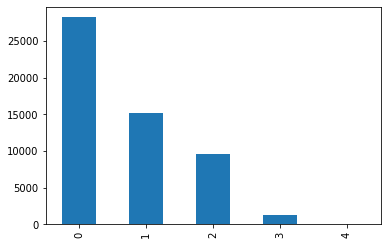

In [12]:
no_qual_races['no_qual_races_min'].value_counts().plot(kind = 'bar')

In [13]:
# drop unncessary columns
no_qual_races = no_qual_races[['no_qual_races_min']]
no_qual_races

,no_qual_races_min
race_id,
16022,0
16809,0
16895,0
16896,0
16897,0
...,...
4642020,1
4642021,2
4642022,1


# Store Features

In [14]:
features_dict = {'features':[min_avg_time, min_avg_stime, win_place_show_fin],
                 'no_qual_races': no_qual_races}
pickle.dump(features_dict, open(os.path.join(DATA_DIR, 'features_dict_25days.p'), 'wb'))